# INTEGRAL SCW Catalog Query Tutorial

This notebook demonstrates how to query and analyze INTEGRAL Science Window (ScW) catalogs using the `ScwQuery` class.

A Science Window is INTEGRAL's basic observational unit, typically lasting 30-60 minutes. Each SCW contains:
- **Pointing information**: Where the satellite was looking (RA, Dec)
- **Time information**: When the observation occurred (start/stop times)
- **Quality metrics**: Data quality indicators (chi-squared values)
- **Revolution**: INTEGRAL's orbital revolution number

## 1. Installation & Setup
<div class="alert alert-block alert-info">
<b>If not installed:</b> pip install isgri
</div>




In [1]:
from isgri.catalog import ScwQuery
from isgri.utils import ijd2utc
import matplotlib.pyplot as plt
import numpy as np

## 2. Loading Data

In [ ]:
catalog_path = "/path/to/your/scw_catalog.fits"
cat = ScwQuery(catalog_path)

# Alternatively:
# cat = ScwQuery()
# cat._catalog = catalog # Directly assign a catalog object

## 3. Basic info


In [3]:
print(f"Total SCWs in catalog: {cat.count()}")
print(f"Time range: {cat.catalog['TSTART'].min():.1f} - {cat.catalog['TSTOP'].max():.1f} IJD")
print(f"Revolutions: {cat.catalog['REVOL'].min()} - {cat.catalog['REVOL'].max()}")

Total SCWs in catalog: 208127
Time range: 1046.7 - 9045.5 IJD
Revolutions: 10 - 2831


## 4. Time filtering

In [4]:
# Select ScWs before 2010-01-01
scws_pre2010 = cat.time(tstop="2010-01-01").get()
cat.reset()
print(f"SCWs before 2010-01-01: {len(scws_pre2010)}")

SCWs before 2010-01-01: 65863


In [5]:
# Select Scws after 2011-01-01
scws_post2011 = cat.time(tstart="2011-01-01").get()
cat.reset()
print(f"SCWs after 2011-01-01: {len(scws_post2011)}")

SCWs after 2011-01-01: 132310


In [6]:
# Select ScWs not between 2010-01-01 and 2011-01-01 -- ScwQuery does not support NOT queries directly, but the result can be obtained by combining two queries
from astropy.table import vstack

scws_not_2010_2011 = vstack([scws_pre2010, scws_post2011])
print(f"SCWs not between 2010-01-01 and 2011-01-01: {len(scws_not_2010_2011)}")

SCWs not between 2010-01-01 and 2011-01-01: 198173


In [7]:
# ScWs between 2010-01-01 and 2011-01-01
scws_2010_2011 = cat.time(tstart="2010-01-01", tstop="2011-01-01").get()
cat.reset()

print(f"SCWs between 2010-01-01 and 2011-01-01: {len(scws_2010_2011)}")

SCWs between 2010-01-01 and 2011-01-01: 9956


In [8]:
# Alternatively, IJD or MJD times can be used.
scws_ijd = cat.time(tstart=2000.0, tstop=2500.0).get()
cat.reset()
print(f"SCWs between IJD 2000.0 and 2500.0: {len(scws_ijd)}")

SCWs between IJD 2000.0 and 2500.0: 11985


In [9]:
scws_mjd = cat.time(tstart=(2000 + 51544.0), tstop=(2500 + 51544.0)).get()  # MJD = IJD + 51544.0
cat.reset()
print(f"SCWs between MJD 53544.0 and 54044.0: {len(scws_mjd)}")

SCWs between MJD 53544.0 and 54044.0: 11985


## 5. Select ScWs by revolution number

In [10]:
# Select ScWs from revolution 500
rev500 = cat.revolution(500).get()
cat.reset()
print(f"SCWs in revolution 500: {len(rev500)}, min_rev: {rev500['REVOL'].min()}, max_rev: {rev500['REVOL'].max()}")

SCWs in revolution 500: 59, min_rev: 500, max_rev: 500


In [11]:
# Select ScWs from revolutions 500 to 510
revs = np.arange(500, 511).tolist()
print(f"Revolutions to select: {revs}")
rev500_510 = cat.revolution(revs).get()
cat.reset()
print(
    f"SCWs in revolutions 500 to 510: {len(rev500_510)}, min_rev: {rev500_510['REVOL'].min()}, max_rev: {rev500_510['REVOL'].max()}"
)

Revolutions to select: [500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510]
SCWs in revolutions 500 to 510: 538, min_rev: 500, max_rev: 510


## 6. Quality filtering

In [12]:
# Data with chi-squared < 2.0 (constant background & no flaring sources)

chi = cat.quality(2.0).get()
cat.reset()
print(f"SCWs with chi-squared < 2.0: {len(chi)}, percent: {len(chi)/cat.count()*100:.2f}%")

SCWs with chi-squared < 2.0: 187272, percent: 89.98%


In [13]:
# Data with sigma clipping < 2.0

cutchi = cat.quality(2.0, chi_type="CUT_CHI").get()
cat.reset()
print(f"SCWs with CUT_CHI < 2.0: {len(cutchi)}, percent: {len(cutchi)/cat.count()*100:.2f}%")

SCWs with CUT_CHI < 2.0: 181605, percent: 87.26%


In [14]:
# Data with GTI chi-squared < 2.0
gticut = cat.quality(2.0, chi_type="GTI_CHI").get()
cat.reset()
print(f"SCWs with GTI_CHI < 2.0: {len(gticut)}, percent: {len(gticut)/cat.count()*100:.2f}%")

SCWs with GTI_CHI < 2.0: 190513, percent: 91.54%


## 7. Position-based search

In [15]:
# Crab coordinates: RA=83.63°, Dec=22.01°
crab_ra, crab_dec = 83.632, 22.017

In [16]:
# Find SCWs pointing within 10° of Crab
results = cat.position(ra=crab_ra, dec=crab_dec, radius=10.0).get()
cat.reset()
print(f"SCWs within 10° of Crab: {len(results)}")

SCWs within 10° of Crab: 9020


In [17]:
# Find SCWs pointing within 10° of Crab using HH:MM:SS, DD:MM:SS
crab_ra_hms = "05 34 31.78"
crab_dec_dms = "22 01 02.6"
results = cat.position(ra=crab_ra_hms, dec=crab_dec_dms, radius=10.0).get()
cat.reset()
print(f"SCWs within 10° of Crab: {len(results)}")

SCWs within 10° of Crab: 9020


In [18]:
# Alternatively, use SkyCoord -- any coordinate system supported by Astropy can be used
from astropy.coordinates import SkyCoord

crab_coord = SkyCoord(ra=crab_ra, dec=crab_dec, unit="deg")
results2 = cat.position(target=crab_coord, radius=10.0).get()
cat.reset()
print(f"SCWs within 10° of Crab (SkyCoord): {len(results2)}")

SCWs within 10° of Crab (SkyCoord): 9020


In [19]:
# Get offsets for each SCW
results_with_offsets = cat.position(ra=crab_ra, dec=crab_dec, radius=10.0).get_offsets(ra=crab_ra, dec=crab_dec)
print(f"\nFirst 5 SCWs:")
cat.reset()
print(results_with_offsets["SWID", "Y_OFFSET", "Z_OFFSET", "MAX_OFFSET"][:5])


First 5 SCWs:
    SWID           Y_OFFSET             Z_OFFSET            MAX_OFFSET     
------------ -------------------- -------------------- --------------------
003900020010 0.004450675587459483 0.002701215970365634 0.004450675587459483
003900020020 0.004450675587459483 0.002701215970365634 0.004450675587459483
003900020030 0.004450675587459483 0.002701215970365634 0.004450675587459483
003900020040 0.004450675587459483 0.002701215970365634 0.004450675587459483
003900020050 0.004450675587459483 0.002701215970365634 0.004450675587459483


In [20]:
# Find ScWs with Crab within fully coded field of view
fully_coded = cat.position(ra=crab_ra, dec=crab_dec, fov_mode="full").get()
cat.reset()
print(f"SCWs with Crab within fully coded FOV: {len(fully_coded)}")

SCWs with Crab within fully coded FOV: 6977


In [21]:
# Find ScWs with Crab within field of view  (at any offset)
partially_coded = cat.position(ra=crab_ra, dec=crab_dec, fov_mode="any").get()
cat.reset()
print(f"SCWs with Crab within partially coded FOV: {len(partially_coded)}")

SCWs with Crab within partially coded FOV: 42363


## 8. Combining filters

In [22]:
# Find fully-coded Crab observations in 2010 with chi-squared < 2.0

crab_2010 = (
    cat.time(tstart="2010-01-01", tstop="2010-12-31")
    .quality(max_chi=2.0)
    .position(ra=crab_ra, dec=crab_dec, fov_mode="full")
    .get()
)
cat.reset()
print(f"\nFully-coded Crab observations in 2010 with chi-squared < 2.0: {len(crab_2010)}")


Fully-coded Crab observations in 2010 with chi-squared < 2.0: 141


In [23]:
# Alternatively, combine multiple criteria step by step
cat.time(tstart="2010-01-01", tstop="2010-12-31")
cat.quality(max_chi=2.0)
cat.position(ra=crab_ra, dec=crab_dec, fov_mode="full")
stepwise_crab_2010 = cat.get()
cat.reset()
print(f"\nFully-coded Crab observations in 2010 with chi-squared < 2.0 (stepwise): {len(stepwise_crab_2010)}")


Fully-coded Crab observations in 2010 with chi-squared < 2.0 (stepwise): 141


## 9. Visualize sky coverage

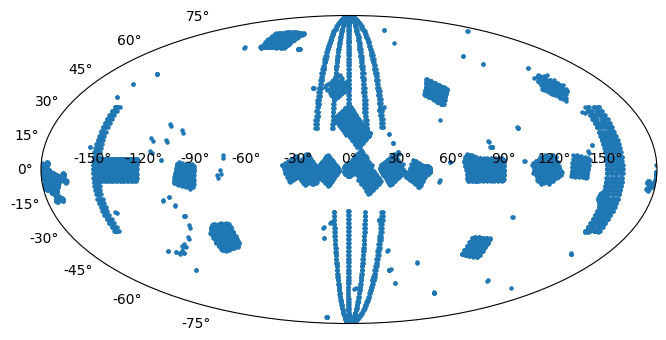

In [24]:
import astropy.units as u

# Get all pointings in 2010
pointings_2010 = cat.time(tstart="2010-01-01", tstop="2010-12-31").get()
cat.reset()

ra = pointings_2010["RA_SCX"]
dec = pointings_2010["DEC_SCX"]
# convert to galactic
coords = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame="icrs")
l = coords.galactic.l.wrap_at(180 * u.deg).radian
b = coords.galactic.b.radian

plt.figure(figsize=(8, 4))
ax = plt.subplot(111, projection="mollweide")
ax.scatter(l, b, s=5)

## 9. Export results

In [25]:
export_data = (
    cat.position(ra=crab_ra, dec=crab_dec, fov_mode="full").quality(max_chi=2.0).get_offsets(ra=crab_ra, dec=crab_dec)
)

# Save to FITS only ScWs identifiers, skip all other columns
export_data[["SWID"]].write("crab_good_scws.fits", overwrite=True)
print(f"Exported {len(export_data)} SCWs to 'crab_good_scws.fits'")

# Or save as CSV (here we save all columns)
export_data.write("crab_good_scws.csv", format="ascii.csv", overwrite=True)
print(f"Exported {len(export_data)} SCWs to 'crab_good_scws.csv'")

Exported 5442 SCWs to 'crab_good_scws.fits'
Exported 5442 SCWs to 'crab_good_scws.csv'


## 10. Summary of query methods

In [26]:
print("Summary: Available query methods")
print("=" * 60)
print(
    """
cat.time(tstart=..., tstop=...)           # Filter by time range
cat.quality(max_chi=..., chi_type=...)    # Filter by data quality
cat.position(ra=..., dec=..., radius=...) # Filter by sky position
cat.revolution(revs)                       # Filter by revolution(s)

cat.get()                                  # Get filtered results
cat.get_offsets(ra=..., dec=...)          # Get results with offset columns
cat.count()                                # Count matching SCWs
cat.reset()                                # Clear all filters

# Chain multiple filters:
results = (cat
    .time(tstart="2010-01-01")
    .quality(max_chi=2.0)
    .position(ra=83.63, dec=22.01, fov_mode='full')
    .get()
)
"""
)

Summary: Available query methods

cat.time(tstart=..., tstop=...)           # Filter by time range
cat.quality(max_chi=..., chi_type=...)    # Filter by data quality
cat.position(ra=..., dec=..., radius=...) # Filter by sky position
cat.revolution(revs)                       # Filter by revolution(s)

cat.get()                                  # Get filtered results
cat.get_offsets(ra=..., dec=...)          # Get results with offset columns
cat.count()                                # Count matching SCWs
cat.reset()                                # Clear all filters

# Chain multiple filters:
results = (cat
    .time(tstart="2010-01-01")
    .quality(max_chi=2.0)
    .position(ra=83.63, dec=22.01, fov_mode='full')
    .get()
)

